# Example 10

The use case from the user manual. The example does not contain anything that is not covered in the previous examples.

In [1]:
import calfem.core as cfc
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv
import calfem.utils as cfu
import numpy as np

from scipy.sparse import lil_matrix

In [2]:
%matplotlib notebook

## Problem parameters

In [3]:
t = 0.2
v = 0.35
E1 = 2e9
E2 = 0.2e9
ptype = 1
ep = [ptype,t]
D1 = cfc.hooke(ptype, E1, v)
D2 = cfc.hooke(ptype, E2, v)

# Define marker constants instead of using numbers in the code

mark_E1 = 55
mark_E2 = 66
mark_fixed = 70
mark_load = 90

# Create dictionary for the different element properties

elprop = {}
elprop[mark_E1] = [ep, D1]
elprop[mark_E2] = [ep, D2]

# Parameters controlling mesh

el_size_factor = 0.05    # Element size factor
el_type = 3             # Triangle element
dofs_per_node = 2        # Dof per node

## Create geometry

In [4]:
g = cfg.Geometry()

### Add points

In [5]:
g.point([0, 0])		#0
g.point([1, 0])		#1
g.point([1, 1])		#2
g.point([0, 1])		#3
g.point([0.2, 0.2])	#4
g.point([0.8, 0.2])	#5
g.point([0.8, 0.8])	#6
g.point([0.2, 0.8])	#7

### Add curves

In [6]:
g.spline([0, 1], marker = mark_fixed) #0
g.spline([2, 1])                     #1
g.spline([3, 2], marker = mark_load)  #2
g.spline([0, 3])                     #3
g.spline([4, 5])                     #4
g.spline([5, 6])                     #5
g.spline([6, 7])                     #6
g.spline([7, 4])                     #7

### Add surfaces

In [7]:
g.surface([0,1,2,3], holes = [[4,5,6,7]], marker = mark_E1)
g.surface([4,5,6,7], marker = mark_E2)

## Create mesh

In [8]:
mesh = cfm.GmshMeshGenerator(g)
mesh.el_size_factor = el_size_factor
mesh.el_type = el_type  
mesh.dofs_per_node = dofs_per_node

# Mesh the geometry:
#  The first four return values are the same as those that trimesh2d() returns.
#  value elementmarkers is a list of markers, and is used for finding the 
#  marker of a given element (index).

coords, edof, dofs, bdofs, elementmarkers = mesh.create()

## Solve problem

### Assemble system

In [12]:
nDofs = np.size(dofs)
K = lil_matrix((nDofs,nDofs))
ex, ey = cfc.coordxtr(edof, coords, dofs)

for eltopo, elx, ely, elMarker in zip(edof, ex, ey, elementmarkers):

    if el_type == 2:
        Ke = cfc.plante(elx, ely, elprop[elMarker][0], elprop[elMarker][1])
    else:
        Ke = cfc.planqe(elx, ely, elprop[elMarker][0], elprop[elMarker][1])
        
    cfc.assem(eltopo, K, Ke)

### Solve equation system

In [13]:
bc = np.array([],'i')
bcVal = np.array([],'i')

bc, bcVal = cfu.applybc(bdofs, bc, bcVal, mark_fixed, 0.0)

f = np.zeros([nDofs,1])

cfu.applyforcetotal(bdofs, f, mark_load, value = -10e5, dimension=2)

a,r = cfc.spsolveq(K, f, bc, bcVal)

### Calculate element forces

In [14]:
ed = cfc.extractEldisp(edof, a)
von_mises = []

for i in range(edof.shape[0]):
    
    # Handle triangle elements
        
    if el_type == 2: 
        es, et = cfc.plants(ex[i,:], ey[i,:], 
                        elprop[elementmarkers[i]][0], 
                        elprop[elementmarkers[i]][1], 
                        ed[i,:])
        
        von_mises.append( np.math.sqrt( pow(es[0,0],2) - es[0,0]*es[0,1] + pow(es[0,1],2) + 3*pow(es[0,2],2) ) )

    else:
        
        # Handle quad elements
        
        es, et = cfc.planqs(ex[i,:], ey[i,:], 
                        elprop[elementmarkers[i]][0], 
                        elprop[elementmarkers[i]][1], 
                        ed[i,:])
        
        von_mises.append( np.math.sqrt( pow(es[0],2) - es[0]*es[1] + pow(es[1],2) + 3*pow(es[2],2) ) )

## Visualise results

### Geometry

<IPython.core.display.Javascript object>


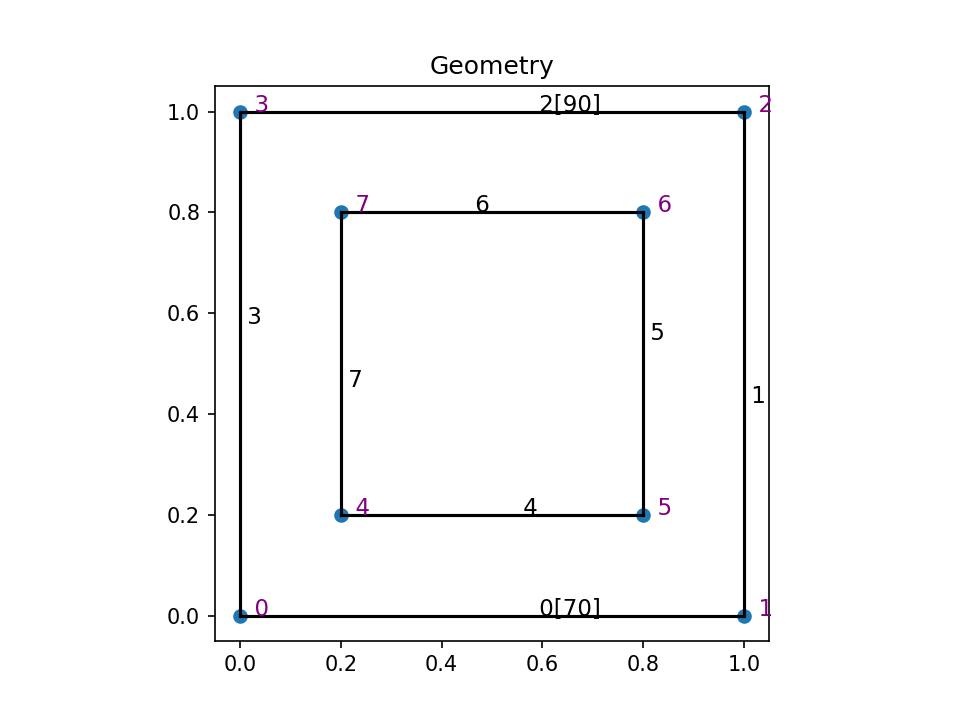

In [15]:
cfv.figure() 
cfv.draw_geometry(g, title="Geometry")

### Mesh

<IPython.core.display.Javascript object>


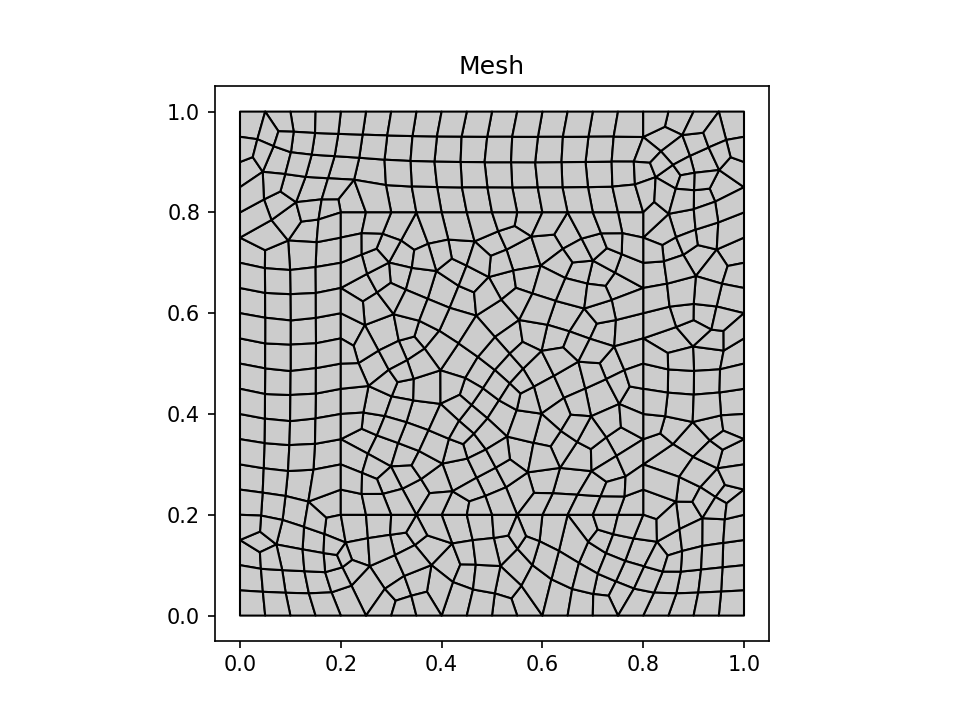

In [16]:
cfv.figure() 
cfv.draw_mesh(coords=coords, edof=edof, dofs_per_node=dofs_per_node, el_type=el_type, 
             filled=True, title="Mesh") #Draws the mesh.

### Displacements

<IPython.core.display.Javascript object>


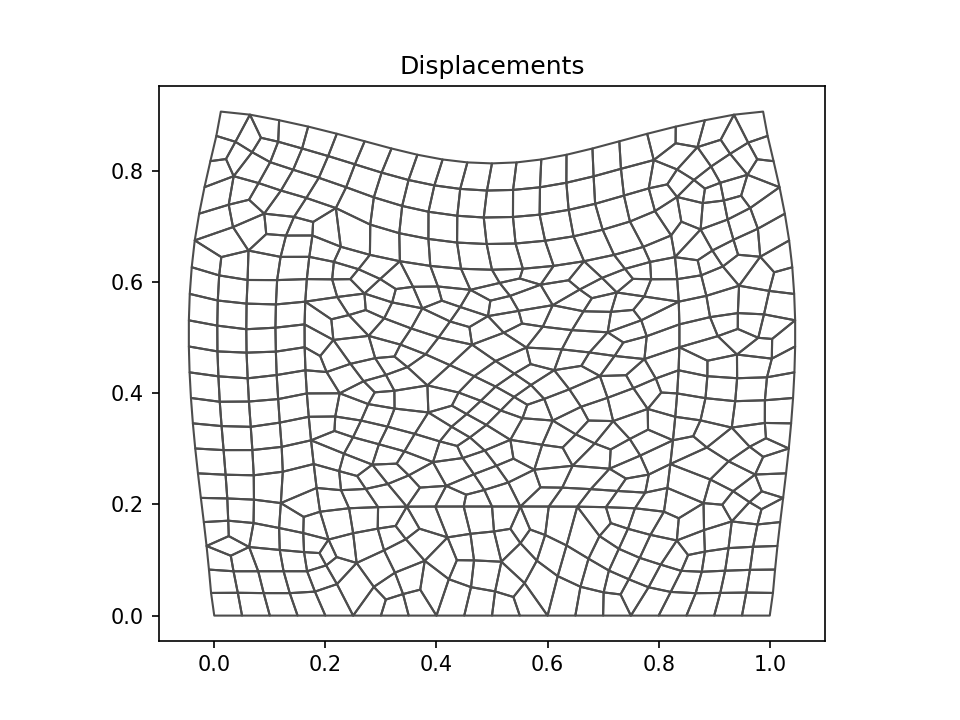

In [17]:
cfv.figure()
cfv.draw_displacements(a, coords, edof, dofs_per_node, el_type, 
                      draw_undisplaced_mesh=False, title="Displacements", 
                      magnfac=25.0)

### Element values

<IPython.core.display.Javascript object>


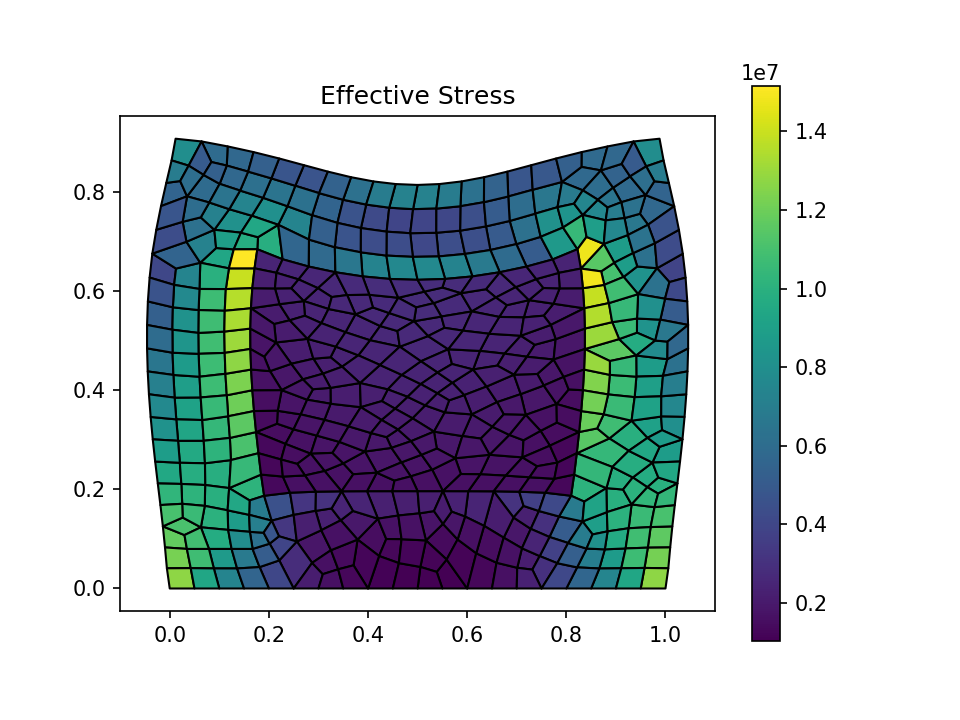

In [18]:
cfv.figure()
cfv.draw_element_values(von_mises, coords, edof, dofs_per_node, el_type, a, 
                      draw_elements=True, draw_undisplaced_mesh=False, 
                      title="Effective Stress", magnfac=25.0)

cfv.colorbar()